# Proyecto 04 - Sistemas de Recomendación v2.0

Este proyecto partirá del análisis y modelo desarrollado en el Proyecto 3. El objetivo de este proyecto es desarrollarar dos nuevos modelos de filtro colaborativo, utilizando diferentes medidas de similitud (uno utilizando la similitud coseno y otro BM25). También se continuará analizando el modelo de ALS desarrollado en el proyecto 3, pero se utilizará el método bayesiano para optimizar los hiperparametros y reducir considerablemente los tiempos de procesamiento.

## Dataset: STEAM

**[Aquí](https://github.com/kang205/SASRec) se puede descargar el Dataset de STEAM. Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

## Contenido de este Notebook

1. Análisis exploratorio del Dataset.
2. Transformaciones para los modelos.
3. Desarrollo de modelos y optimización de hiperparametros.
4. Análisis sobre un usuario aleatorio.
5. Conclusiones.

### 0. descargamos las librerías que utilizaremos ###



In [1]:
import gzip
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="Blues_d")


def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

#### **Reviews** ####

Se descargan los datos de las reviews y se los pasara a un archivo .csv debido a que el proceso de descarga demora un tiempo considerable. 

In [2]:
# %%time
# contador = 0
# data_reviews = []
# # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# # abrira uno de cada tres, y asi.
# n = 1
# for l in parse('steam_reviews.json.gz'):
#     if contador%n == 0:
#         data_reviews.append(l)
#     else:
#         pass
#     contador += 1
# data_reviews = pd.DataFrame(data_reviews)

# data_reviews.to_csv('data_reviews.csv',index=False)


data_reviews = pd.read_csv('data_reviews.csv')

In [3]:
print(f'Nº de filas: {data_reviews.shape[0]}')
print(f'Nº de columnas: {data_reviews.shape[1]}')
print('\n')

print('Nombre de las columnas: ')
for col in data_reviews.columns:
    print(col)

print('\n')


Nº de filas: 7793069
Nº de columnas: 12


Nombre de las columnas: 
username
hours
products
product_id
page_order
date
text
early_access
page
found_funny
compensation
user_id




#### **Games** ####

Se descargarán los datos de los juegos y se lo pasara a un archivo .csv para facilitar el posterior acceso.

In [4]:
# %%time
# data_games = []
# for l in parse('steam_games.json.gz'):
#     data_games.append(l)
# data_games = pd.DataFrame(data_games)
# data_games.to_csv('data_games.csv',index=False)

data_games = pd.read_csv('data_games.csv')

In [5]:
print(f'Nº de filas: {data_games.shape[0]}')
print(f'Nº de columnas: {data_games.shape[1]}')
print('\n')

print('Nombre de las columnas: ')
for col in data_games.columns:
    print(col)

print('\n')


Nº de filas: 32135
Nº de columnas: 16


Nombre de las columnas: 
publisher
genres
app_name
title
url
release_date
tags
discount_price
reviews_url
specs
price
early_access
id
developer
sentiment
metascore




***
### 1. Análisis exploratorio ###

#### 1. Data Reviews ####

In [6]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


In [7]:
data_reviews.isna().sum()

username            208
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text              17972
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

Se descartaran las columnas `products`,`page_order`,`date`, `early_acces`,`page`,`found_funny` y `compensation` debido a que no contienen información relevante. `user_id` debido a que hay tantos valores vacíos se descartara y se utilizara `username` para referenciar a los usuarios y `text` si bien es la columna que contiene la información sobre la opinión del usuario hacia el juego pero debido a que es texto no se encuentra en el alcance de este proyecto.

In [8]:
dr = data_reviews[['username','product_id','hours']].copy()

Se incorpora el título del juego para visualizar mejor.

In [9]:
data_games.rename(columns={'id':'product_id'},inplace=True)
dr = dr.merge(data_games[['product_id','title']],on='product_id')

In [10]:
dr.isna().sum()

username        208
product_id        0
hours         26537
title             0
dtype: int64

Los datos vacíos de `username` y `hours` serán descartados, debido a que son un muy pequeño porcentaje a la totalidad de los datos.

In [11]:
dr.dropna(inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,Chaos Syren,725280,0.1,Psi Project
1,Teef 🐏,725280,0.9,Psi Project
2,nd,725280,1.0,Psi Project
3,Sneaky_Panda,725280,0.6,Psi Project
4,wasp99rock,725280,0.3,Psi Project
...,...,...,...,...
7772790,Joish,518790,13.9,theHunter: Call of the Wild™
7772791,Proxwian,518790,44.2,theHunter: Call of the Wild™
7772792,XsurbanatorX,518790,0.2,theHunter: Call of the Wild™
7772793,Proxwian,518790,44.2,theHunter: Call of the Wild™


Se descartarán los duplicados, en el caso de que haya diferencia en `hours` se mantendrá el mayor valor.

In [12]:
dr.sort_values(by=['username','product_id','hours'],ascending=False,inplace=True)
dr.drop_duplicates(subset=['username','product_id'],inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀗THE0ERROR󰀗,322330,99.0,Don't Starve Together
1,󰀗THE0ERROR󰀗,204300,138.1,Awesomenauts - the 2D moba
2,󰀗S-Rabbit󰀗,322330,116.0,Don't Starve Together
3,󰀗 Lolicage,244630,7.5,NEOTOKYO
4,󰀖Mr.Tarunio,391540,22.1,Undertale
...,...,...,...,...
6863837,!,386360,6.5,SMITE®
6863838,!,377160,123.3,Fallout 4
6863839,!,304240,42.7,Resident Evil / biohazard HD REMASTER
6863840,!,227940,20.9,Heroes &amp; Generals


* #### username ####

In [13]:
user = dr['product_id'].groupby(dr['username']).agg('count').reset_index()
user.sort_values(ascending=False,inplace=True,by='product_id')
user.rename(columns={'product_id':'count'},inplace=True)
print('Usuarios con mayor cantidad de juegos')
print(user.head(20))


Usuarios con mayor cantidad de juegos
                 username  count
1342846       Saint Aaron   1236
856805           Kodyd194   1103
1660152  VahidSlayerOfAll    885
91307                Alex    869
1104270              Nick    862
302615              Chris    805
1609864               Tom    805
1344613            Salarn    774
19607                  ..    735
1353495           Sarkoth    730
1838183              alel    730
2174400        mark | dj.    718
988487               Matt    703
377947                Dan    695
1336801     STEVEN AGEVER    662
1017012              Mike    645
753661               Jack    643
26895                 123    632
1346613               Sam    631
1178700    Paradise Decay    631


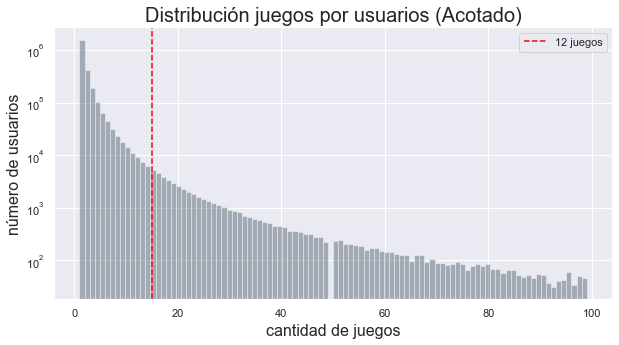

In [14]:
fig = plt.figure(figsize = (10,5))
sns.distplot(user['count'][user['count']<100],kde=False,bins=100)
plt.ylabel("número de usuarios",fontsize=16)
plt.xlabel("cantidad de juegos",fontsize=16)
plt.yscale('log')
plt.title('Distribución juegos por usuarios (Acotado)',fontsize=20)
plt.axvline(x=15, c='r', ls='--', label='12 juegos')
plt.legend()

plt.show()

In [15]:
dat=user.shape[0]
print('Cantidad usuarios: ',dat)

dat2=user[user['count']<12].shape[0]
print('Cantidad de usuarios con menos de 12 juegos: ',dat2)

res_dat=user['count'][user['count']<12].sum()
res=dr.shape[0]
dat3=round((res_dat/res)*100,2)

print('Porcentaje de reseñas de usuarios con menos de 12 juegos: ',dat3,'%')

Cantidad usuarios:  2563307
Cantidad de usuarios con menos de 12 juegos:  2487464
Porcentaje de reseñas de usuarios con menos de 12 juegos:  69.87 %


Se define que un usuario es relevante para el modelo si tienen menos de 12 juegos. Si bien la cantidad de reseñas de los usuarios con menos de 12 juegos son casi un 70% del total de las reseñas, esto va a generar un dataset más homogéneo y el modelo producirá mejores resultados.

* #### product_id ####

In [16]:
games = dr['username'].groupby(dr['product_id']).agg('count').reset_index()
games = games.merge(data_games[['product_id','title']],on='product_id')
games.sort_values(ascending=False,inplace=True,by='username')
games.drop(columns='product_id',axis=1,inplace=True)
games = games[['title','username']]
games.rename(columns={'username':'count'},inplace=True)
print('¿Cuáles son los juegos más populares?')
print(games.head(20))

¿Cuáles son los juegos más populares?
                            title   count
19                Team Fortress 2  121324
2212                         Rust   68031
1003                Borderlands 2   50574
6118                    Fallout 4   48041
3458                    Robocraft   45612
2684           Grand Theft Auto V   41843
6657                    Undertale   40306
1655                         DayZ   39697
1792                     Warframe   38858
22                       Portal 2   38845
1763        Heroes &amp; Generals   35823
3998  Life is Strange - Episode 1   35115
140                   Garry's Mod   33660
4900        ARK: Survival Evolved   30558
8040                         H1Z1   30498
1515                    Starbound   30056
1243                       Arma 3   28868
8365                    Paladins®   28648
255   Sid Meier's Civilization® V   25921
994    Mount &amp; Blade: Warband   25654


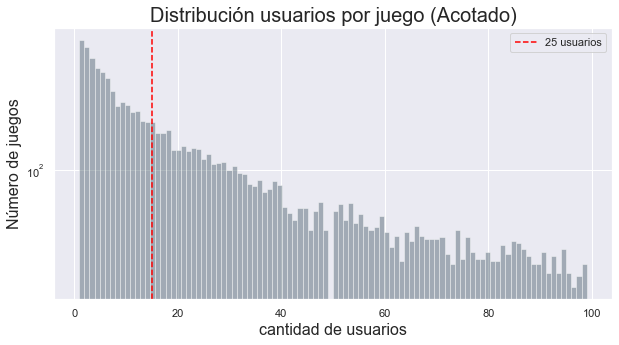

In [17]:
fig = plt.figure(figsize = (10,5))

sns.distplot(games['count'][games['count']<100],kde=False,bins=100)
plt.ylabel("Número de juegos",fontsize=16)
plt.yscale('log')
plt.axvline(x=15, c='r', ls='--', label='25 usuarios')
plt.xlabel("cantidad de usuarios",fontsize=16)
plt.title('Distribución usuarios por juego (Acotado)',fontsize=20)
plt.legend()
plt.show()

In [18]:
dat=games.shape[0]
print('Cantidad juegos: ',dat)

dat2=games[games['count']<25].shape[0]
print('Cantidad de juegos con menos de 25 usuarios: ',dat2)

dat3=round((dat2/dat)*100,2)
print('Cantidad de juegos con menos de 25 usuarios (Porcentaje): ',dat3,'%')

res_dat=games['count'][games['count']<25].sum()
res=dr.shape[0]
dat3=round((res_dat/res)*100,2)

print('Porcentaje de reseñas de juegos con menos de 25 usuarios: ',dat3,'%')

Cantidad juegos:  15391
Cantidad de juegos con menos de 25 usuarios:  6835
Cantidad de juegos con menos de 25 usuarios (Porcentaje):  44.41 %
Porcentaje de reseñas de juegos con menos de 25 usuarios:  0.89 %


Los juegos con menos de 25 usuarios equivalen a menos del 1% de las reseñas totales, por lo que se descartaran. 

* #### hours ####

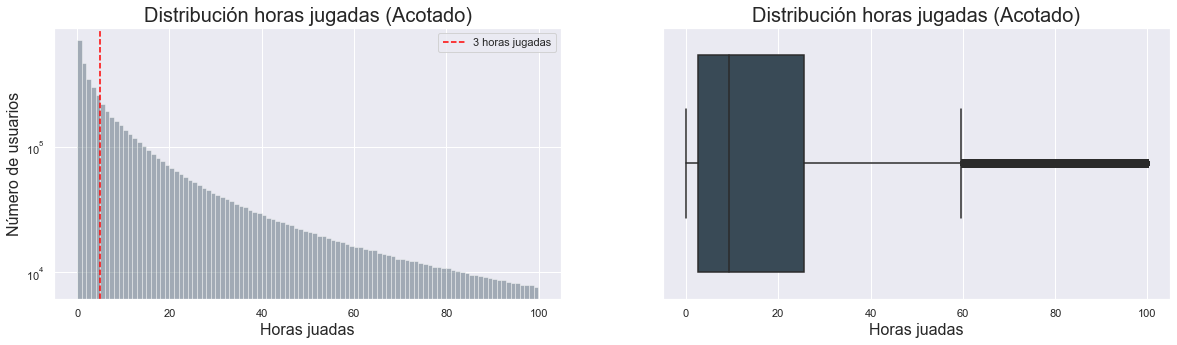

In [19]:
fig = plt.figure(figsize = (10*2,5))
plt.subplot(1,2,1)
sns.distplot(dr['hours'][dr['hours']<100],kde=False,bins=100)
plt.xlabel('Horas juadas',fontsize=16)
plt.yscale('log')
plt.ylabel('Número de usuarios',fontsize=16)
plt.axvline(x=5, c='r', ls='--', label='3 horas jugadas')
plt.legend()
plt.title('Distribución horas jugadas (Acotado)',fontsize=20)

plt.subplot(1,2,2)
sns.boxplot(dr['hours'][dr.hours<100])
plt.xlabel('Horas juadas',fontsize=16)
plt.title('Distribución horas jugadas (Acotado)',fontsize=20)


plt.show()

In [20]:
dat=dr['hours'].shape[0]
print('Cantidad reviews: ',dat)

dat2=dr['hours'][dr.hours<5].shape[0]
print('Cantidad de reviews con menos de 5 horas jugadas: ',dat2)
dat3=round((dat2/dat)*100,2)
print('Cantidad de reviews con menos de 5 horas jugadas (Porcentaje): ',dat3,'%')


Cantidad reviews:  6863842
Cantidad de reviews con menos de 5 horas jugadas:  2074187
Cantidad de reviews con menos de 5 horas jugadas (Porcentaje):  30.22 %


Hay una gran cantidad de usuarios que jugaron menos de 5 horas, que se puede considerar un tiempo suficiente para categorizar al usuario como que jugo el juego. 

***
***

#### 2. Data Games ####

In [21]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,product_id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


Se descartaran las columnas `app_name`, `url`, `realease_date`, `dicount_price`, `reviews_url`, `early_acces`, `developer` y `metascore` dado que no contienen información relevante.

In [22]:
dg=data_games[['publisher','app_name','genres','tags','specs','price','product_id','sentiment']].copy()

In [23]:
dg.drop_duplicates(inplace=True)
dg.isna().sum()

publisher     8062
app_name         2
genres        3283
tags           163
specs          670
price         1377
product_id       2
sentiment     7182
dtype: int64

* #### publisher ####

In [24]:
dg['publisher'].fillna(value='',inplace=True)

games = dg['product_id'].groupby(dg['publisher']).agg('count').reset_index()
games.sort_values(ascending=False,inplace=True,by='product_id')
games.rename(columns={'product_id':'count'},inplace=True)
print('¿Cuales son los desarrolladores con mas juegos?')
print(games.head(20))

¿Cuales son los desarrolladores con mas juegos?
                                              publisher  count
0                                                         8061
7256                                            Ubisoft    385
2020                            Dovetail Games - Trains    360
1835                                             Degica    286
5141                                Paradox Interactive    271
5957                                               SEGA    251
2016                            Dovetail Games - Flight    220
3697                         KOEI TECMO GAMES CO., LTD.    208
261                                          Activision    202
858                                      Big Fish Games    195
3685                                           KISS ltd    189
2012                                     Dovetail Games    176
6757                                         THQ Nordic    170
1251                                             Capcom    155
6590   

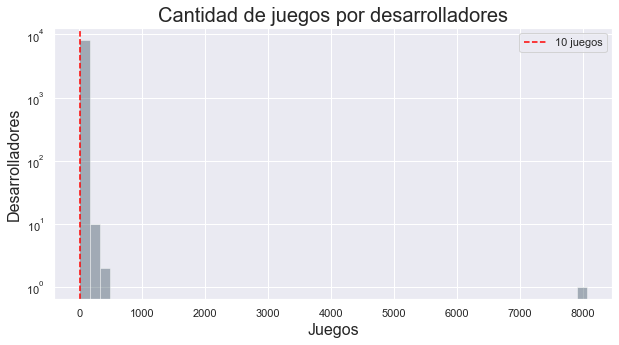

In [25]:
fig = plt.figure(figsize = (10,5))
sns.distplot(games['count'],kde=False,bins=50)
plt.yscale('log')
plt.xlabel('Juegos',fontsize=16)
plt.axvline(x=10, c='r', ls='--', label='10 juegos')
plt.ylabel('Desarrolladores',fontsize=16)
plt.legend()
plt.title('Cantidad de juegos por desarrolladores',fontsize=20)
plt.show()

In [26]:
dat=games['count'].shape[0]
print('Cantidad de desarrolladores: ',dat)

dat2=games['count'][games['count']<5].shape[0]
print('Cantidad de desarrolladores con menos de 10 juegos: ',dat2)

dat3=round((dat2/dat)*100,2)
print('Cantidad de desarrolladores con menos de 10 juegos (Porcentaje): ',dat3,'%')

Cantidad de desarrolladores:  8238
Cantidad de desarrolladores con menos de 10 juegos:  7571
Cantidad de desarrolladores con menos de 10 juegos (Porcentaje):  91.9 %


* #### genres ####

In [27]:
pd.set_option('mode.chained_assignment', None)

if dg.tags.isna().sum() !=0:
    dg.genres.loc[dg.genres.notnull()]=dg.genres.loc[dg.genres.notnull()].apply(lambda row: ast.literal_eval(row))

    for row in dg.loc[dg.genres.isnull(), 'tags'].index:
        dg.genres.loc[row]=[]
    
generos=dg['genres'].sum()

values, counts = np.unique(generos, return_counts=True)

In [28]:
sort_index=np.argsort(counts)[::-1]
values=[values[i] for i in sort_index]
counts=[counts[i] for i in sort_index]

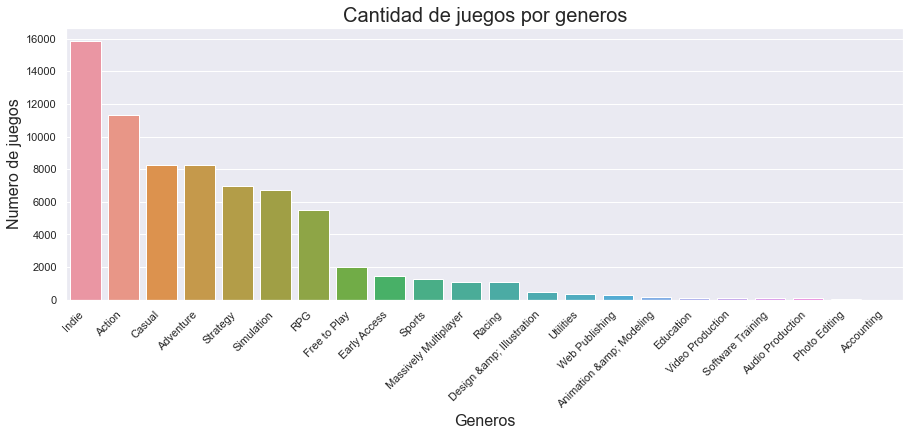

In [29]:
fig = plt.figure(figsize = (15,5))
sns.barplot(x = values, y = counts)
plt.xticks(rotation=45,ha='right')
plt.xlabel('Generos',fontsize=16)
plt.ylabel('Numero de juegos',fontsize=16)
plt.title('Cantidad de juegos por generos',fontsize=20)
plt.show()

* #### tags ####

In [30]:
pd.set_option('mode.chained_assignment', None)

if dg.tags.isna().sum() !=0:
    dg.tags.loc[dg.tags.notnull()]=dg.tags.loc[dg.tags.notnull()].apply(lambda row: ast.literal_eval(row))

    for row in dg.loc[dg.tags.isnull(), 'tags'].index:
        dg.tags.loc[row]=[]
    
tags=dg['tags'].sum()

values, counts = np.unique(tags, return_counts=True)
    

In [31]:
sort_index=np.argsort(counts)[::-1]
values=[values[i] for i in sort_index]
counts=[counts[i] for i in sort_index]

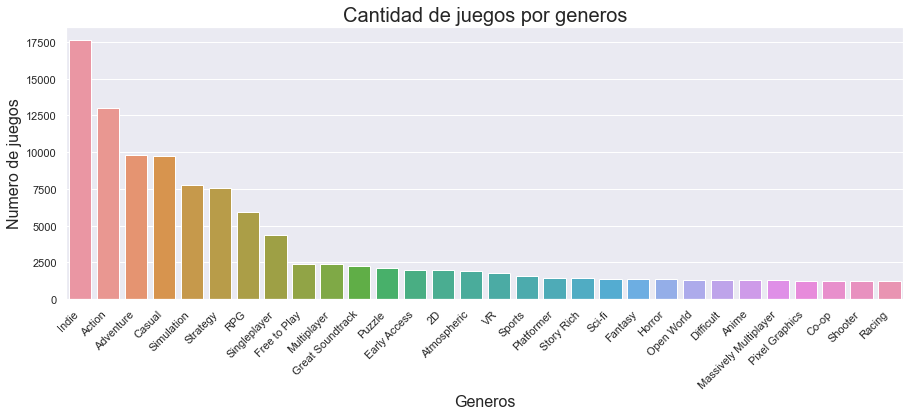

In [32]:
fig = plt.figure(figsize = (15,5))
sns.barplot(x = values[:30], y = counts[:30])
plt.xticks(rotation=45,ha='right')
plt.xlabel('Generos',fontsize=16)
plt.ylabel('Numero de juegos',fontsize=16)
plt.title('Cantidad de juegos por generos',fontsize=20)
plt.show()

* #### specs ####

In [33]:
pd.set_option('mode.chained_assignment', None)

if dg.specs.isna().sum() !=0:
    dg.specs.loc[dg.specs.notnull()]=dg.specs.loc[dg.specs.notnull()].apply(lambda row: ast.literal_eval(row))

    for row in dg.loc[dg.specs.isnull(), 'specs'].index:
        dg.specs.loc[row]=[]
    
specs=dg['specs'].sum()

values, counts = np.unique(specs, return_counts=True)

In [34]:
sort_index=np.argsort(counts)[::-1]
values=[values[i] for i in sort_index]
counts=[counts[i] for i in sort_index]

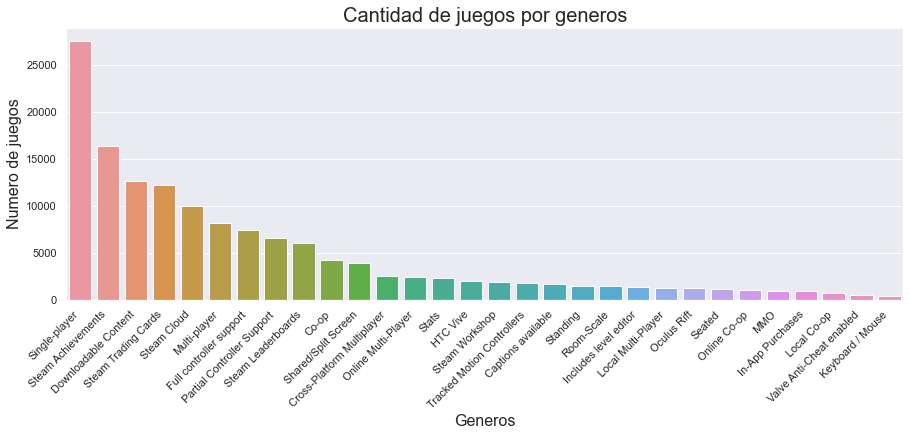

In [35]:
fig = plt.figure(figsize = (15,5))
sns.barplot(x = values[:30], y = counts[:30])
plt.xticks(rotation=45,ha='right')
plt.xlabel('Generos',fontsize=16)
plt.ylabel('Numero de juegos',fontsize=16)
plt.title('Cantidad de juegos por generos',fontsize=20)
plt.show()

* #### price ####

In [36]:
dg['price'].fillna(value=0,inplace=True)

precio=['Free to Play','Free To Play','Free','Play for Free!','Play WARMACHINE: Tactics Demo','Play the Demo','Free Mod','Free to Use','Install Now','Free to Try','Third-party','Free Movie','Free HITMAN™ Holiday Pack','Install Theme','Free Demo','Play Now']

precio_nuevo=['0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0']

dg.price.replace(precio,precio_nuevo,inplace=True)
dg.price.replace('Starting at $449.00','449.00',inplace=True)
dg.price.replace('Starting at $499.00','499.00',inplace=True)

dg.price.unique()
dg.price=dg.price.astype('float16')

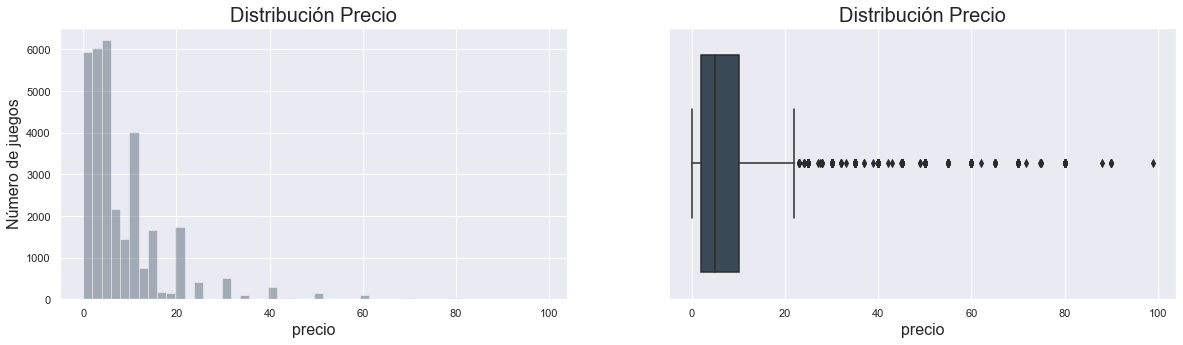

In [37]:
fig = plt.figure(figsize = (10*2,5))
plt.subplot(1,2,1)
sns.distplot(dg['price'][dg.price<100],kde=False)
plt.xlabel('precio',fontsize=16)
plt.ylabel('Número de juegos',fontsize=16)
plt.title('Distribución Precio',fontsize=20)

plt.subplot(1,2,2)
sns.boxplot(dg['price'][dg.price<100])
plt.xlabel('precio',fontsize=16)
plt.title('Distribución Precio',fontsize=20)


plt.show()

* #### product ID ####

In [38]:
dg.dropna(subset=['product_id'],inplace=True)

* #### Sentiment ####

In [39]:
dg['sentiment'].fillna(value=0,inplace=True)
sen=dg.product_id.groupby(by=dg.sentiment).agg('count').reset_index()
sen

,sentiment,product_id
0,0,7181
1,1 user reviews,2496
2,2 user reviews,1756
3,3 user reviews,1231
4,4 user reviews,964
5,5 user reviews,846
6,6 user reviews,756
7,7 user reviews,619
8,8 user reviews,537
9,9 user reviews,488


***
### 2. Transformaciones para los modelos ###

Dado que se desarrollarán modelos de filtro colaborativo solo se utilizará el dataset games reviews. 

* Se descartarán las reviews con menos de 5hs jugadas, por lo visto en el análisis exploratorio.

In [40]:
ind = dr.hours[dr['hours']<5].index
dr.drop(index=ind,inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀗THE0ERROR󰀗,322330,99.0,Don't Starve Together
1,󰀗THE0ERROR󰀗,204300,138.1,Awesomenauts - the 2D moba
2,󰀗S-Rabbit󰀗,322330,116.0,Don't Starve Together
3,󰀗 Lolicage,244630,7.5,NEOTOKYO
4,󰀖Mr.Tarunio,391540,22.1,Undertale
...,...,...,...,...
4789650,!,386360,6.5,SMITE®
4789651,!,377160,123.3,Fallout 4
4789652,!,304240,42.7,Resident Evil / biohazard HD REMASTER
4789653,!,227940,20.9,Heroes &amp; Generals


* Se descartarán todos los usuarios con menos de 12 reviews, para homogeneizar el dataset.

In [41]:
usu = dr['product_id'].groupby(dr['username']).agg(['count']).reset_index()
dr = pd.merge(dr,usu,on='username')
ind = dr[dr['count']<=12].index
dr.drop(index=ind,inplace=True)
dr.drop(['count'],axis=1,inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀈Spectra󰀈,588430,60.3,Fallout Shelter
1,󰀈Spectra󰀈,401680,5.4,POSTAL Redux
2,󰀈Spectra󰀈,397550,40.2,Deus Ex: Revision
3,󰀈Spectra󰀈,364470,83.2,The Elder Scrolls®: Legends™
4,󰀈Spectra󰀈,319630,19.3,Life is Strange - Episode 1
...,...,...,...,...
957958,! Taz the Husky,40100,58.9,Supreme Commander 2
957959,! Taz the Husky,39680,18.1,The Guild II Renaissance
957960,! Taz the Husky,17570,9.2,"Pirates, Vikings, and Knights II"
957961,! Taz the Husky,17500,171.0,Zombie Panic! Source


* Se descartarán los juegos con menos de 25 reviews, estos juegos no cumplen con la suficiente cantidad de usuarios para ser recomendados.

In [42]:
usu = dr['username'].groupby(dr['product_id']).agg(['count']).reset_index()
dr = pd.merge(dr,usu,on='product_id')
ind = dr[dr['count']<=25].index
dr.drop(index=ind,inplace=True)
dr.drop(['count'],axis=1,inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀈Spectra󰀈,588430,60.3,Fallout Shelter
1,󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡,588430,21.8,Fallout Shelter
2,💚 Lewy,588430,19.5,Fallout Shelter
3,🎉,588430,19.4,Fallout Shelter
4,🍁Yoo Bro🍁,588430,5.9,Fallout Shelter
...,...,...,...,...
910388,Big Boss,381990,110.4,Dragon Saga
910389,BattleBuddy,381990,40.8,Dragon Saga
910390,Batman,381990,263.3,Dragon Saga
910391,BOB,381990,1172.7,Dragon Saga


Se crea un código nuevo para los usuarios y los items.

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

dr['userid'] = le.fit_transform(dr['username'])
dr['productid'] = le.fit_transform(dr['product_id'])
dr['play'] = 1

Se utilizará la librería sparse para crear las matrices de utilidad.

In [44]:
import scipy.sparse as sparse

item_user = sparse.csr_matrix((dr['play'].astype(float), (dr['productid'].astype(int), dr['userid'].astype(int))))
user_item = sparse.csr_matrix((dr['play'].astype(float), (dr['userid'].astype(int), dr['product_id'].astype(int))))


***
### 3. Desarrollo de modelos y optimización de hiperparametros ###

Se utilizará la librería [Implicit](https://implicit.readthedocs.io/en/latest/), que se especializa en el manejo de Datasets de feedback implicito. Los modelos seleccionados para el desarrollo son:

* K vecinos más cercanos (KNN) utilizando la medida de similitud coseno
* K vecinos más cercanos (KNN) utilizando la medida de similitud BM25
* Mínimos cuadrados alternantes (ALS)

#### K vecinos más cercanos (KNN) ####

El algoritmo de KNN considera los K elementos (siendo K un hiperparámetro) más cercanos al elemento del cual se desea predecir su interacción o preferencia y califica dicha interacción según la observación de las interacciones conocidas cercanas.

En el sistema de recomendación basado en contenidos desarrollado emplea media de similitud coseno a sobre la matriz de características de los items y los sistemas tipo filtro colaborativo basados en memoria utilizan medidas de similitud coseno y BM25 sobre la matriz de utilidad item - usuario.

#### Mínimos cuadrados alternante ####
El modelo elegido es el de mínimos cuadrados alternantes, este es un modelo de factores latentes, al igual que SVD. Este tipo de modelos típicamente asocian cada usuario $u$ dentro del conjunto total de usuarios $U$ con un vector factor usuario $x_{u}$ y cada item $i$ dentro del conjunto total de items $I$ con un vector factor item $y_{i}$. 

Los valores de la matriz de interacción son eventos que tienen preferencias y confianza específicas, que dan el valor de cada elemento. Debido a que se está desarrollando un modelo implícito, se introducirá un conjunto de variables binarias, donde será 1 si el usuario jugo el juego más de una hora y 0 para el resto.

$$p_{ui}=\begin{cases} 1& \ hours > 1\\ 0& \ hours < 1 \end{cases}$$

Confianza es la interacción entre el usuario u y el item, escalada en el valor α.

$$c_{ui} = \alpha p_{ui}$$ 

La función de costo del método es la siguiente:

$${min}_{x,y} \sum_{u,i} c_{ui}(p_{ui} - x_{u}^{T}y_{i})^{2} + \lambda \bigg(\sum_{u} \|x_{u}\|^{2} + \sum_{i} \|y_{i}\|^{2}\bigg)$$

Finalmente, el término $\lambda$ se utiliza para regularizar el modelo y su valor se puede determinar mediante validación cruzada.

La minimización de esta función se desarrolla con el método de gradiente conjugado desarrollado en el artículo [Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.379.6473&rep=rep1&type=pdf).


#### Optimización bayesiana para los hiperparámetros ####

Para aquellos que poseen varios hipeparámetros se desarrollara un procedimiento de [optimización bayesiana](https://machinelearningmastery.com/what-is-bayesian-optimization/), utilizando la libreria [scikit-optimize](https://scikit-optimize.github.io/stable/) para los hiperparámetros utilizando procesos gausianos. La idea de este procedimiento es aproximar la función de costo como la superposición de funciones gausianas y a partir de este enfoque evaluar la métrica obtenida con cada iteración para buscar la configuración de hiperparámetros que minimice la función de costo.

La gran ventaja que tiene este enfoque es el algoritmo aprende de los resultados anteriores y se ajusta hasta cumplir con las condiciones solicitadas de convergencia, a diferencia de la optimización por grilla o randomizado que requiere un gran número de iteraciones, lo que se ve reflejado en tiempos de ejecución mucho mayores.


In [45]:
import os

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender
from implicit.evaluation import train_test_split, ranking_metrics_at_k

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.plots import plot_convergence

os.environ['MKL_NUM_THREADS'] = '1'

Se dividirá el dataset para entrenar los modelos y evaluarlo con la métrica.

In [46]:
train,test = train_test_split(item_user,train_percentage=0.8)

***
#### 0. Modelo ALS - Proyecto 3 ####

Los hiperparametros definidos son:
* `alpha` = 28
* `factors`= 20
* `regularization` = 0.7525
* `iterations` = 40

In [47]:
alpha_val = 28
data_conf = (item_user * alpha_val).astype('double')
train, test = train_test_split(data_conf,train_percentage=0.8)
model = AlternatingLeastSquares(factors=20,regularization=0.7525,iterations=40)
model.fit(train)

In [48]:
metric_ALS = ranking_metrics_at_k(model, train.T, test.T, K=20)

print('MAP ALS - Proyecto 3:',round(metric_ALS['map'],5))


MAP ALS - Proyecto 3: 0.05027



#### 1. Modelo de Benchmark ####

Se realizará un modelo de benchmark comparando los TOP 10 items más populares. Para esto se creará una clase que recomiende según el score propuesto según la popularidad de los items.

In [49]:
ranking = dr.productid.value_counts().index
score = np.linspace(10,-10,len(ranking))
recomendations = list(tuple(zip(ranking, score)))

In [50]:
class Benchmark:
    def __init__(self, recomendations):
        self.recomendations = recomendations
        
    def recommend(self, userid, user_item, N):
        recomendations = self.recomendations[:N]
        return recomendations

In [51]:
model_Benchmark = Benchmark(recomendations)

In [52]:
metrics_benchmark = ranking_metrics_at_k(model_Benchmark, train.T, test.T, K=20, show_progress=True)
print('MAP benchmark: ',round(metrics_benchmark['map'],5))


MAP benchmark:  0.02919


#### 2. K vecinos mas cercanos (KNN) - Similitud coseno ####

Debido a que este modelo solo tiene un hiperparametro, se realizara la optimización utilizando la iteración.

In [53]:
%%time

Ks = np.arange(1,50)
metric_KNN_cos = []


for K in Ks:
    model = CosineRecommender(K=K)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, show_progress=False)
    metric_KNN_cos.append(r['map'])

Wall time: 1min 27s


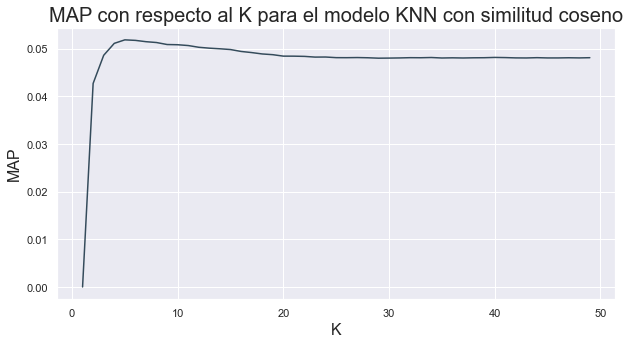

In [54]:
fig = plt.figure(figsize = (10,5))
plt.title('MAP con respecto al K para el modelo KNN con similitud coseno',fontsize=20)
plt.plot(Ks, metric_KNN_cos)
plt.xlabel('K',fontsize=16)
plt.ylabel('MAP',fontsize=16)
plt.grid(True)

In [55]:
model = CosineRecommender(K=6)
model.fit(train, show_progress=True)

In [56]:
metric_KNN_cos = ranking_metrics_at_k(model, train.T, test.T, K=20, show_progress=True)

print('MAP KNN - Sim. Coseno:',round(metric_KNN_cos['map'],3))


MAP KNN - Sim. Coseno: 0.052


#### 3. K vecinos mas cercanos (KNN) - Similitud BM25 ####

In [57]:
search_space = [Integer(2, 100, name='Ks'), 
                 Real(0, 20, name='K1s'), 
                 Real(0, 20, name='Bs')]

In [58]:

@use_named_args(search_space)
def evaluate_model(Ks, K1s, Bs):
    model = BM25Recommender(K=Ks, K1=K1s, B=Bs)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, show_progress=False)
    return 1 - r['map']

In [59]:
callback1 = DeltaYStopper(delta=1.5e-3, n_best=5)
callback2 = DeadlineStopper(total_time=60*20)

In [60]:
%%time

optimization = gp_minimize(evaluate_model, search_space, n_calls=200, callback=[callback1,callback2], random_state=42)

Wall time: 2min 30s


In [61]:
print('el modelo tiene un valor de MAP igual a :',(1- optimization.fun))

el modelo tiene un valor de MAP igual a : 0.056523191524845195


In [62]:
print('Los hiperparámetros para el modelo optimizado son:')
print('K : ',optimization.x[0])
print('K1 : ',optimization.x[1])
print('B : ',optimization.x[2])

Los hiperparámetros para el modelo optimizado son:
K :  100
K1 :  3.160759537794063
B :  2.836574454782369


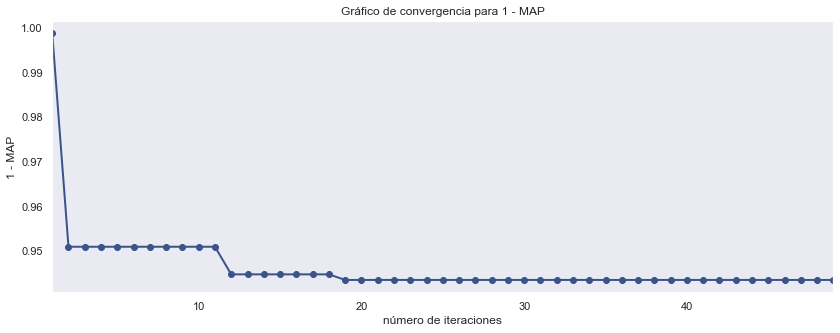

In [63]:
plt.figure(figsize=(14,5))
plot_convergence(optimization)
plt.title('Gráfico de convergencia para 1 - MAP')
plt.xlabel('número de iteraciones')
plt.ylabel('1 - MAP')
plt.xlim(1,len(optimization.func_vals))
plt.show()

In [64]:
model = BM25Recommender(K=optimization.x[0], K1=optimization.x[1], B=optimization.x[2])
model.fit(train, show_progress=True)

In [65]:
metric_KNN_BM25 = ranking_metrics_at_k(model, train.T, test.T, K=20, show_progress=True)
print('MAP KNN - Sim. BM25:',round(metric_KNN_BM25['map'],3))


MAP KNN - Sim. BM25: 0.057



#### 4. Mínimos cuadrados alternantes (ALS) ####



In [66]:
search_space = [Integer(5, 100, name='alfa'),
                 Integer(10, 400, name='fact'),
                 Real(10, 300, name='reg'),
                 Integer(20, 150, name='ite')]

In [67]:
@use_named_args(search_space)
def evaluate_model(alfa, fact, reg, ite):
    trainALS, testALS = train_test_split(item_user * alfa, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=fact, regularization=reg, iterations=ite, random_state=42)
    model.fit(trainALS, show_progress=False)
    r = ranking_metrics_at_k(model, trainALS.T, testALS.T, K=20, show_progress=False)
    return 1 - r['map']

In [68]:
callback1 = DeltaYStopper(delta=1.5e-3, n_best=5)
callback2 = DeadlineStopper(total_time=60*60*2)

In [69]:
%%time

optimization = gp_minimize(evaluate_model, search_space, n_calls=200, callback=[callback1,callback2], random_state=42)

Wall time: 1h 49min 38s


In [70]:
print('el modelo tiene un valor de MAP igual a :', (1- optimization.fun))

el modelo tiene un valor de MAP igual a : 0.0683529205841178


In [71]:
print('Los hiperparámetros para el modelo optimizado son los siguiente')
print('alpha : ',optimization.x[0])
print('factor latente : ',optimization.x[1])
print('regularización : ',optimization.x[2])
print('iteraciones : ',optimization.x[3])

Los hiperparámetros para el modelo optimizado son los siguiente
alpha :  37
factor latente :  400
regularización :  300.0
iteraciones :  150


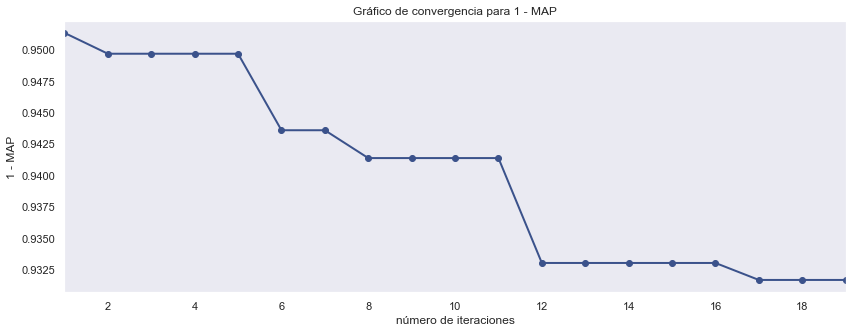

In [72]:
plt.figure(figsize=(14,5))
plot_convergence(optimization)
plt.title('Gráfico de convergencia para 1 - MAP')
plt.xlabel('número de iteraciones')
plt.ylabel('1 - MAP')
plt.xlim(1,len(optimization.func_vals))
plt.show()

In [75]:
alpha_val = 32
data_conf = (item_user * alpha_val).astype('double')
train, test = train_test_split(data_conf,train_percentage=0.8)
model = AlternatingLeastSquares(factors=400,regularization=300.0,iterations=150)
model.fit(train)

In [76]:
metric_ALS = ranking_metrics_at_k(model, train.T, test.T, K=20)

print('MAP ALS:',round(metric_ALS['map'],5))


MAP ALS: 0.06737


***
#### Comparacion de metricas de los modelos ####

In [77]:
metrics={'MAP ALS - Proyecto 3' :round(metric_ALS['map'],5),
         'MAP benchmark': round(metrics_benchmark['map'],5),
         'MAP KNN - Sim. Coseno': round(metric_KNN_cos['map'],5),
         'MAP KNN - Sim. BM25': round(metric_KNN_BM25['map'],5),
         'MAP ALS': round(metric_ALS['map'],5)}

metrics=pd.DataFrame.from_dict(metrics,columns=['MAP'],orient='index')

In [78]:
metrics.sort_values(by='MAP',ascending=False)

,MAP
MAP ALS - Proyecto 3,0.06737
MAP ALS,0.06737
MAP KNN - Sim. BM25,0.05652
MAP KNN - Sim. Coseno,0.05175
MAP benchmark,0.02919


En el análisis posterior se utilizará el modelo ALS con el método de optimización Bayesiano dado que es el que presenta mejores resultados. 

***
### 4. Análisis sobre un usuario aleatorio ###

A partir de un usuario aleatorio y del modelo entrenado, se buscan las recomendaciones, la similitud entre items y usuarios. A partir del top recomendaciones y la similitud de los items, se puede esperar que los items más similares estén en la lista de items del usuario. Al mismo tiempo se puede esperar que los usuarios más similares compartan ciertos items.

In [79]:
user = 10032
user_name = dr['username'][dr.userid==user].to_list()[0]
list_games = dr['title'][dr.userid==user].to_list()
list_games.sort()
list_games_codes = dr['productid'][dr.userid==user].to_list()

In [80]:
print('Usuario:',user_name)
print('N° de juegos: ', len(list_games))
print('Juegos: ',list_games)

Usuario: Glitch
N° de juegos:  94
Juegos:  ['2064: Read Only Memories', 'A Hat in Time', 'A Story About My Uncle', "AKIBA'S TRIP: Undead ＆ Undressed", 'ARK: Survival Evolved', 'AdVenture Capitalist', 'Antichamber', 'Arma 2: Operation Arrowhead', 'Arma 3', 'Assassin’s Creed® Brotherhood', 'Batman: Arkham Asylum Game of the Year Edition', 'Batman™: Arkham Origins', 'BioShock® 2', 'Blender', 'Borderlands 2', 'Clickteam Fusion 2.5', 'Crusader Kings II', 'Crusaders of the Lost Idols', 'DOOM', 'Darkest Dungeon®', 'Darksiders II Deathinitive Edition', 'DayZ', 'Divinity: Original Sin (Classic)', 'Dragon Age: Origins - Ultimate Edition', 'Dreamfall Chapters', 'Duelyst', 'EARTH DEFENSE FORCE 4.1 The Shadow of New Despair', 'Edge of Space', 'Euro Truck Simulator 2', 'F1 2016', 'FTL: Faster Than Light', 'Factorio', 'Fallout 4', "Five Nights at Freddy's", "Five Nights at Freddy's 2", "Five Nights at Freddy's 4", 'Fran Bow', "Garry's Mod", 'HELLDIVERS™', 'Hero Siege', 'Heroes &amp; Generals', 'Hurtw

In [81]:
recomendacion=model.recommend(userid=user, user_items=user_item, N=20, filter_items=list_games_codes)

In [82]:
games = []
scores = []
print('Recomendaciones para el usuario: \n')
for i in range(len(recomendacion)):
    game = dr['title'][dr.productid==recomendacion[i][0]].to_list()[0]
    score = recomendacion[i][1]
    
    games.append(game)
    scores.append(score)
    
recom = pd.Series(scores,games)
print(recom)

Recomendaciones para el usuario: 

Undertale                           1.066310
Clicker Heroes                      1.035607
Grand Theft Auto V                  1.035020
Life is Strange - Episode 1         1.021710
Brawlhalla                          1.003982
Rust                                0.938833
The Binding of Isaac                0.883545
Awesomenauts - the 2D moba          0.861304
Risk of Rain                        0.858413
H1Z1                                0.854262
Portal 2                            0.845354
Sid Meier's Civilization® V         0.840014
The Walking Dead: Season 2          0.829025
SpeedRunners                        0.787880
Saints Row IV                       0.786949
No More Room in Hell                0.786111
BioShock™                           0.783457
Torchlight II                       0.781139
Realm of the Mad God                0.767362
Middle-earth™: Shadow of Mordor™    0.740173
dtype: float64


Se busca los items similares a la recomendación número 1.

In [83]:
top_item = recomendacion[0][0]

similar = model.similar_items(itemid=top_item,N=15)

In [84]:
games = []
scores = []
print('Juegos similares a la recomendación N°1: \n')
for i in range(len(similar)):
    game = dr['title'][dr.productid==similar[i][0]].to_list()[0]
    score = similar[i][1]
    
    games.append(game)
    scores.append(score)
    
recom = pd.Series(scores,games)
print(recom)

Juegos similares a la recomendación N°1: 

Undertale                           1.000000
Team Fortress 2                     0.376993
OneShot                             0.365230
PewDiePie: Legend of the Brofist    0.335447
Starbound                           0.319955
The Desolate Hope                   0.313636
The Sandbox                         0.311893
Garry's Mod                         0.307757
Five Nights at Freddy's             0.306065
Rakuen                              0.302229
Suits: A Business RPG               0.298132
Cuphead                             0.297068
Shovel Knight: Treasure Trove       0.295652
The Binding of Isaac: Rebirth       0.292816
Hotline Miami                       0.287973
dtype: float64


In [85]:
cont = 0
sim_games=[]
for i in games:
    if i in list_games:
        cont+=1
        sim_games.append(i)
        
print('Número de juegos similares a la recomendación N°1 que tiene el usuario: ',cont)
print('Juegos: ',sim_games)

Número de juegos similares a la recomendación N°1 que tiene el usuario:  5
Juegos:  ['Team Fortress 2', 'Starbound', "Garry's Mod", "Five Nights at Freddy's", 'The Binding of Isaac: Rebirth']


Como se esperaba los items con mayor similitud a la primera recomendación se encuentran en la lista del usuario.

In [86]:
sim_user = model.similar_users(userid=user,N=10)

users = []
scores = []
print('Usuarios similares a ',user_name,': \n')
for i in range(len(sim_user)):
    use = dr['username'][dr.userid==sim_user[i][0]].to_list()[0]
    score = sim_user[i][1]
    
    users.append(use)
    scores.append(score)
    
recom = pd.Series(scores,users)
print(recom)

Usuarios similares a  Glitch : 

Glitch      1.000000
Echo        0.461176
Jay         0.452647
Kyle        0.447960
Pulse       0.447960
Kappa       0.442416
alex        0.439936
Infinity    0.435539
Daddy       0.434123
Monika      0.432714
dtype: float64


In [87]:
top_user=sim_user[1][0]
top_user_name = dr['username'][dr.userid==top_user].to_list()[0]
top_list_games = dr['title'][dr.userid==top_user].to_list()


cont = 0
sim_games=[]

for i in top_list_games:
    if i in list_games:
        cont+=1
        sim_games.append(i)
        
print('Número de juegos compartidos con el usuario mas similar: ',cont)
print('Juegos: ',sim_games)

Número de juegos compartidos con el usuario mas similar:  38
Juegos:  ['Team Fortress 2', 'Trove', 'Starbound', 'Borderlands 2', 'Just Cause 2', 'Warframe', 'Hurtworld', 'SMITE®', "Tom Clancy's Rainbow Six® Siege", 'LYNE', "Garry's Mod", 'Fallout 4', 'Arma 3', 'Stardew Valley', 'ARK: Survival Evolved', 'This War of Mine', 'Divinity: Original Sin (Classic)', 'Heroes &amp; Generals', 'Paladins®', 'Factorio', 'Robocraft', 'A Hat in Time', 'Just Cause™ 3', 'Arma 2: Operation Arrowhead', 'Star Conflict', "Five Nights at Freddy's", 'State of Decay', 'Antichamber', 'Crusader Kings II', 'Star Wars: Battlefront 2 (Classic, 2005)', 'Blender', 'Nuclear Throne', 'The Crew™', 'Loadout', 'A Story About My Uncle', "AKIBA'S TRIP: Undead ＆ Undressed", 'FTL: Faster Than Light', 'Crusaders of the Lost Idols']


La similitud de usuarios se puede observar en la gran cantidad de items que comparten.

***
### 5. Conclusión ###

Luego de una profunda exploración de datos y utilizando la librería Implicit se logró obtener un mejor modelo de recomendación para la base de datos de Steam.

Si bien con el modelo de mínimos cuadrados alternante, optimizado con el método Bayesiano, se obtuvieron mejores resultados, los resultados de los modelos KNN son sustancialmente mejores que el modelo Benchmark y mejores que el modelo del proyecto 3. Los tiempos de optimización de hiperparametros se redujeron sustancialmente gracias al método Bayesiano, que en el proyecto 3 fue el limitante del rendimiento del modelo, debido a que para reducir el tiempo de procesamiento se aceptaron resultados de la optimización no tan optimas.

Los tiempos de optimización de los modelos KNN son para tomar en cuenta, si los tiempos son un limitante estos modelos dan buenos resultados y con poco tiempo de procesamiento. 

Se pueden considerar algunas cosas que podrían mejorar el modelo de recomendación: 

* Filtrar los juegos según sus tags y realizar un modelo para cada categoría puede tener mejor precisión al momento de recomendar.

* Hay una columna que no se utilizó en el modelo que es `sentiment` en la base de datos `data_games`, estos datos son una clasificación que nos da Steam obtenido de las reviews de los usuarios, esta columna podría servir al modelo para facilitar la recomendación.

* Un tema que se dijo anteriormente es la aplicación de procesamiento de lenguaje natural en la columna de `text` de `data_reviews` para poder calificar verdaderamente la opinión del usuario al juego.

* Un modelo que no se desarrolló en este proyecto es el modelo basado en contenidos utilizando la base de datos Data Games.

